In [0]:
import time
import numpy as np

from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression


# Logistic Regression

## Overview
Logistic Regression is a function of the form:
$$
p(x) = \frac{1}{1 + e^{-\beta x}} = \frac{e^{\beta x}}{e^{\beta x} + 1}
$$

where \\(\beta\\) is a vector of coefficients, including the intercept, and \\(x\\) is the feature vector.

This is essentially the sigmoid function on top of a OLS regression of the independent variable \\(x \\).

With a logistic regression model, what we're trying to estimate is the \\(\beta\\) coefficients, which fully describe the model.

## Loss function
For logistic regression, the mean squared error is no longer a nice convex loss function, so we use the _logistic loss_ function. Given each prediction \\(p(x)\\) and actual label \\(y\\), the loss function is:
$$
Loss(p(x), y) = -ylog(p(x)) - (1-y)log(1 - p(x))
$$

For batch gradient descent, we simply use the average loss function over a number of data points.

## Gradient
To perform gradient descent, we need to take the derivative of the loss function with respect to the parameters \\(\beta \\).

To derive the gradient, we first simply the loss function a little:
$$Loss(p(x), y) = -ylog(p(x)) - (1-y)log(1 - p(x))$$
$$= -y log(\frac{e^{\beta x}}{1+ e^{\beta x}}) - (1-y)log(1-\frac{e^{\beta x}}{1+ e^{\beta x}})$$
$$= -y(\beta x - log(1+ e^{\beta x}) - (1-y)log(\frac{1}{1+ e^{\beta x}})$$
$$= -y\beta x + ylog(1+ e^{\beta x}) - (1-y)(-log(1+ e^{\beta x}))$$
$$= -y\beta x + ylog(1+ e^{\beta x}) + log(1+ e^{\beta x}) - ylog(1+ e^{\beta x})$$
$$= -y\beta x + log(1+ e^{\beta x})$$

Now using the chain rule to differentiate the loss function with respect to \\(\beta\\) for each data point:
$$ \frac{\partial{Loss}}{\partial \beta} = -yx + \frac{1}{1+ e^{\beta x}} \cdot e^{\beta x} \cdot x $$
$$= -yx + p(x) \cdot x$$
$$= (p(x) - y)\cdot x$$

For batch gradient descent, we again use the average gradient of all the data points multiplied by the learning rate for a gradient update.

In [0]:
# Defining the logistic regression loss
def logit(coefs, x):
    return 1.0 / (np.exp(-np.dot(coefs, x)) + 1)

def LogitLoss(dataRDD, W):
    """
    Compute Logit loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda x: -np.log(logit(W, x[0])) if x[1] > 0.0 else -np.log(1 - logit(W, x[0]))).mean()
    return loss



In [0]:
# Defining one step of gradient descent update
def GDUpdate(dataRDD, W, learningRate = 0.02):
    """
    Perform one Logistic Regression gradient descent step/update.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()

    grad = augmentedData.map(lambda x: (logit(W, x[0]) - x[1]) * x[0]).mean()
    new_model = W - grad * learningRate
    ################## (END) YOUR CODE ################# 
   
    return new_model

In [0]:
# Read some already prepared data from blob storage
blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

df = spark.read.parquet(f"{blob_url}/all_time_all_numeric_data_1")

In [0]:
%run ./dataclean_functions

In [0]:
# Extracting a small section of data 
small_train = undersample(df.filter(F.col("FL_DATE_AIRLNS") == '2015-01-01'), label_col='label')
small_test = df.filter(F.col("FL_DATE_AIRLNS") == '2015-01-02').sample(0.01)
print(small_train.count())
print(small_test.count())

display(small_train.groupBy('label').count())

5658
155

label,count
0.0,2824
1.0,2834


In [0]:
# Standardize data and put into RDD
small_train = small_train.drop('FL_DATE_AIRLNS')
minMaxScaler = MinMaxScaler(inputCol='features', outputCol='features_scaled')
scaler = minMaxScaler.fit(small_train)

small_train_standardized = scaler.transform(small_train).select('features_scaled', 'label')
small_train_standardized_rdd = small_train_standardized.rdd.cache()

small_test_standardized = scaler.transform(small_test).select('features_scaled', 'label')
small_test_standardized_rdd = small_test_standardized.rdd.cache()

In [0]:
# Defining baseline and some iterations on Logistic gradient descent
baseline = np.append([0.5], np.zeros(1114))

nSteps = 5
model = baseline
for i in range(nSteps):
    print(f'step {i}')
    model = GDUpdate(small_train_standardized_rdd, model, learningRate=0.03)
    loss = LogitLoss(small_train_standardized_rdd, model)
    print(f'loss: {loss}')

step 0
loss: 0.6920872666499941
step 1
loss: 0.6907323663102121
step 2
loss: 0.6896994067052201
step 3
loss: 0.6886794066785871
step 4
loss: 0.6876701713406647

In [0]:
# Run model (copied from HW4)
def run_model(trainRDD, testRDD, wInit, nSteps=20, learningRate=0.01):
    train_history, test_history, model_history = [], [], []

    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        model = GDUpdate(trainRDD, model, learningRate=learningRate)
        training_loss = LogitLoss(trainRDD, model)
        test_loss = LogitLoss(testRDD, model)

        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)

        # console output if desired
        print("----------")
        print(f"STEP: {idx+1}")
        print(f"training loss: {training_loss}")
        print(f"test loss: {test_loss}")
    return train_history, test_history, model_history

In [0]:
# plot error curves (copied from HW4)
def plotErrorCurves(trainLoss, testLoss, title = None):
    """
    Helper function for plotting.
    Args: trainLoss (list of MSE) , testLoss (list of MSE)
    """
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    plt.show()

In [0]:
# run 10 iterations (copied from HW4)
wInit = baseline
start = time.time()
loss_train, loss_test, models = run_model(small_train_standardized_rdd, small_test_standardized_rdd, wInit, nSteps=20, learningRate=0.02)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")

----------
STEP: 1
training loss: 0.6971466812039482
test loss: 0.7470294263606523
----------
STEP: 2
training loss: 0.6921887880716875
test loss: 0.7118623015383135
----------
STEP: 3
training loss: 0.6908470902078132
test loss: 0.698832602409416
----------
STEP: 4
training loss: 0.6900614941676216
test loss: 0.6936318330393408
----------
STEP: 5
training loss: 0.6893637792685873
test loss: 0.6913439925711329
----------
STEP: 6
training loss: 0.688683356210758
test loss: 0.6901685325853937
----------
STEP: 7
training loss: 0.6880095783095677
test loss: 0.6894236453118523
----------
STEP: 8
training loss: 0.6873408121337354
test loss: 0.6888474131424388
----------
STEP: 9
training loss: 0.6866767793114363
test loss: 0.6883386237808733
----------
STEP: 10
training loss: 0.6860174054111843
test loss: 0.6878580647110867
----------
STEP: 11
training loss: 0.6853626469116535
test loss: 0.6873905188573215
----------
STEP: 12
training loss: 0.6847124651895304
test loss: 0.6869300677778915
----------
STEP: 13
training loss: 0.6840668226076583
test loss: 0.6864743983628718
----------
STEP: 14
training loss: 0.6834256819258094
test loss: 0.6860225958023048
----------
STEP: 15
training loss: 0.6827890062110855
test loss: 0.6855742877644229
----------
STEP: 16
training loss: 0.6821567588234739
test loss: 0.6851293124831469
----------
STEP: 17
training loss: 0.6815289034126932
test loss: 0.6846875900200365
----------
STEP: 18
training loss: 0.6809054039167225
test loss: 0.6842490723266107
----------
STEP: 19
training loss: 0.68028622456056
test loss: 0.6838137238715207
----------
STEP: 20
training loss: 0.6796713298549955
test loss: 0.6833815141240056

... trained 20 iterations in 1481.2420842647552 seconds

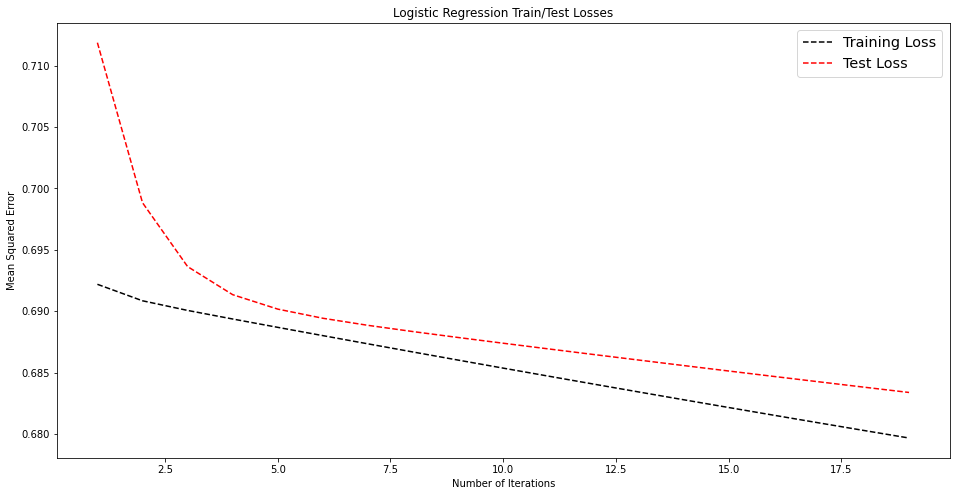

In [0]:
# take a look (copied from HW4)
plotErrorCurves(loss_train, loss_test, title = 'Logistic Regression Train/Test Losses' )

In [0]:
predictions = small_test_standardized_rdd.map(lambda x: ((logit(np.append([1.0], x[0]), models[-1]) > 0.5) * 1.0, x[1])).collect()

In [0]:
predictions

Out[40]: [(0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (0.0, 1.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (1.0, 0.0),
 (0.0, 1.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (0.0, 1.0),
 (0.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (1.0, 1.0),
 (0.0, 0.0),
 (1.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0)]

In [0]:
accuracy = sum([pred == label for pred, label in predictions]) / len(predictions)
true_positive = sum([pred == label == 1 for pred, label in predictions])
true_negative = sum([pred == label == 0 for pred, label in predictions])
false_positive = sum([pred == 1 and label == 0 for pred, label in predictions])
false_negative = sum([pred == 0 and label == 1 for pred, label in predictions])

precision = true_positive * 1.0 / (true_positive + false_positive)
recall = true_positive * 1.0 / (true_positive + false_negative)
print(f"accuracy: {accuracy}")
print(f"precision: {precision}")
print(f"recall: {recall}")
print(f"F-1 score: {2.0 * precision * recall / (precision + recall)}")
print(f"F-2 score: {5.0 * precision * recall / (4 * precision + recall)}")

accuracy: 0.6258064516129033
precision: 0.37662337662337664
recall: 0.7435897435897436
F-1 score: 0.5
F-2 score: 0.6223175965665236